# ConvNeXtLarge: Transfer Learning and Fine Tuning

In [54]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Copia Challenge 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Copia Challenge 1


## Imports

In [55]:
# Fix randomness and hide warnings
seed = 46

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [56]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [57]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications.convnext import preprocess_input

## Loading the data

In [58]:
# Load the data
loaded = np.load('clean_public_data.npz', allow_pickle=True)
data = loaded['data']
labels = loaded['labels']

## One-hot encoding and splitting the data

In [59]:
# Normalize data to the range [0, 1]
data = (data / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
labels = pd.get_dummies(labels)

# Split data into training and validation sets, maintaining class distribution
data_train_val, data_test, labels_train_val, labels_test = train_test_split(data, labels, random_state=seed, test_size=0.1, stratify=labels)

# Split data into training and test sets, maintaining class distribution
data_train, data_val, labels_train, labels_val = train_test_split(data_train_val, labels_train_val, random_state=seed, test_size=0.1, stratify=labels_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", data_train.shape)
print("Training Label Shape:", labels_train.shape)
print("Validation Data Shape:", data_val.shape)
print("Validation Label Shape:", labels_val.shape)
print("Test Data Shape:", data_val.shape)
print("Test Label Shape:", labels_val.shape)

Training Data Shape: (4052, 96, 96, 3)
Training Label Shape: (4052, 2)
Validation Data Shape: (451, 96, 96, 3)
Validation Label Shape: (451, 2)
Test Data Shape: (451, 96, 96, 3)
Test Label Shape: (451, 2)


# Transfer Learning ConvNeXtLarge

In [60]:
# Define key model parameters
input_shape = data_train.shape[1:]    # Input shape for the model
output_shape = labels_train.shape[1]  # Output shape for the model
batch_size = 32                       # Batch size for training
epochs = 200

In [61]:
# Define ConvNeXtLarge network
supernet = tfk.applications.ConvNeXtLarge(
      include_top=False,
      weights="imagenet",
      input_shape=(96,96,3),
      pooling='avg',
      classifier_activation='softmax'
)

supernet.summary()

Model: "convnext_large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 convnext_large_prestem_nor  (None, 96, 96, 3)            0         ['input_3[0][0]']             
 malization (Normalization)                                                                       
                                                                                                  
 convnext_large_stem (Seque  (None, 24, 24, 192)          9792      ['convnext_large_prestem_norma
 ntial)                                                             lization[0][0]']              
                                                                                     

In [62]:
tfk.utils.plot_model(supernet)
supernet.trainable = False

In [63]:
def build_Net(input_shape, output_shape, seed=seed):

  tf.random.set_seed(seed)

  # Define a preprocessing Sequential model with random flip and random rotation
  preprocessing = tf.keras.Sequential([
      tfkl.RandomFlip(mode='horizontal'),
      tfkl.RandomFlip(mode='vertical'),
      tfkl.RandomRotation(factor=0.2)

  ], name='preprocessing')

  inputs = tfk.Input(shape=(96,96,3))

  x = preprocessing(inputs)

  x = supernet(x)
  x = tfkl.Flatten(name='Flattening')(x)
  x = tfkl.Dropout(0.3, seed=seed)(x)

  # Adding a Dense layer and Dropout
  x = tfkl.Dense(256, activation='relu', kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
  x = tfkl.Dropout(0.3, seed=seed)(x)

  output_layer = tfkl.Dense(units=2, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=inputs, outputs=output_layer, name='convnext_large')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(weight_decay=1e-3), metrics=['accuracy'])

  # Return the model
  return model

In [64]:
model = build_Net(input_shape, output_shape)

## Training the model

In [65]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=preprocess_input(data_train*255),
    y=labels_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(preprocess_input(data_val*255), labels_val),
    callbacks=[early_stopping]
).history

Epoch 1/200
127/127 [==============================] - 73s 386ms/step - loss: 0.6132 - accuracy: 0.7280 - val_loss: 0.4104 - val_accuracy: 0.8182
Epoch 2/200
127/127 [==============================] - 34s 268ms/step - loss: 0.4372 - accuracy: 0.7962 - val_loss: 0.3794 - val_accuracy: 0.8248
Epoch 3/200
127/127 [==============================] - 32s 253ms/step - loss: 0.3816 - accuracy: 0.8277 - val_loss: 0.3839 - val_accuracy: 0.8404
Epoch 4/200
127/127 [==============================] - 32s 250ms/step - loss: 0.3801 - accuracy: 0.8295 - val_loss: 0.3069 - val_accuracy: 0.8825
Epoch 5/200
127/127 [==============================] - 31s 245ms/step - loss: 0.3454 - accuracy: 0.8455 - val_loss: 0.3772 - val_accuracy: 0.8337
Epoch 6/200
127/127 [==============================] - 33s 261ms/step - loss: 0.3512 - accuracy: 0.8480 - val_loss: 0.3071 - val_accuracy: 0.8736
Epoch 7/200
127/127 [==============================] - 33s 260ms/step - loss: 0.3363 - accuracy: 0.8477 - val_loss: 0.3201 -

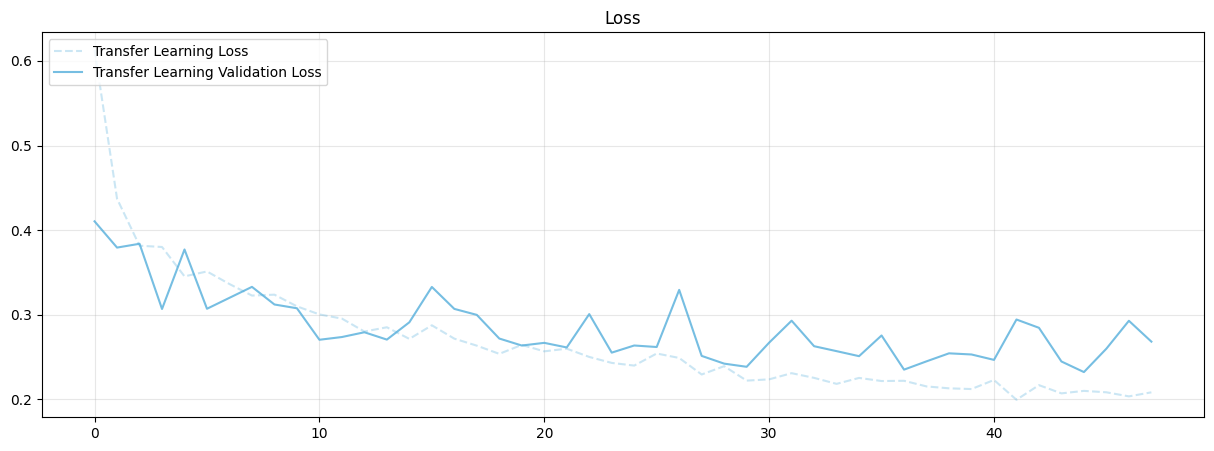

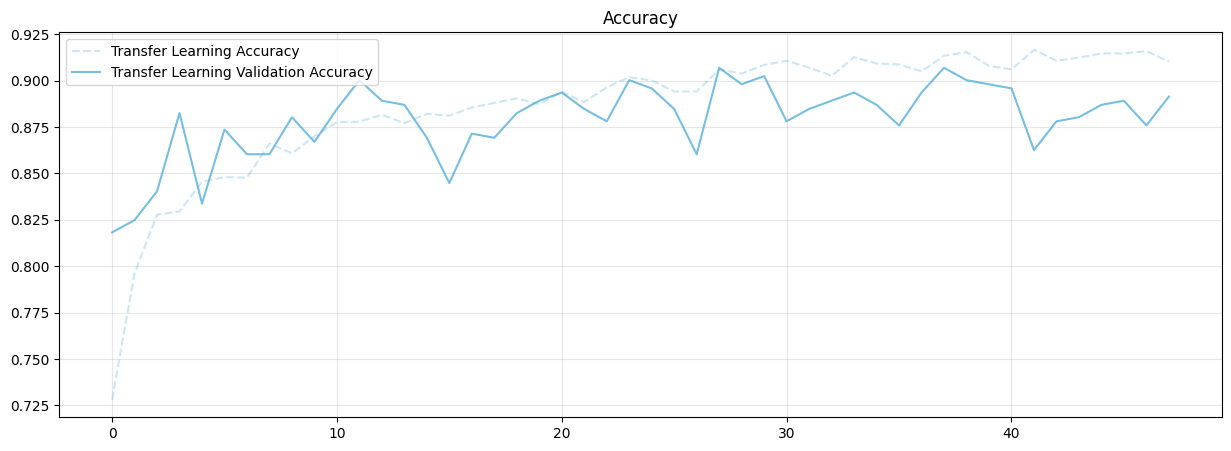

In [66]:
# Plot the transfer learning loss and val loss
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label="Transfer Learning Loss", alpha=.3, color='#54aedb', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning Validation Loss', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)

# Plot the transfer learning accuracy and val accuracy
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Transfer Learning Accuracy', alpha=.3, color='#54aedb', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning Validation Accuracy', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [67]:
# Predict labels for the entire test set
predictions = model.predict(data_test*255, verbose=0)

In [68]:
# Evaluate the model on the test set
test_accuracy = model.evaluate(preprocess_input(data_test*255),labels_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.9042


In [69]:
y = np.array(labels_test)

## Confusion Matrix

Accuracy: 0.9042
Precision: 0.9164
Recall: 0.8824
F1: 0.8946


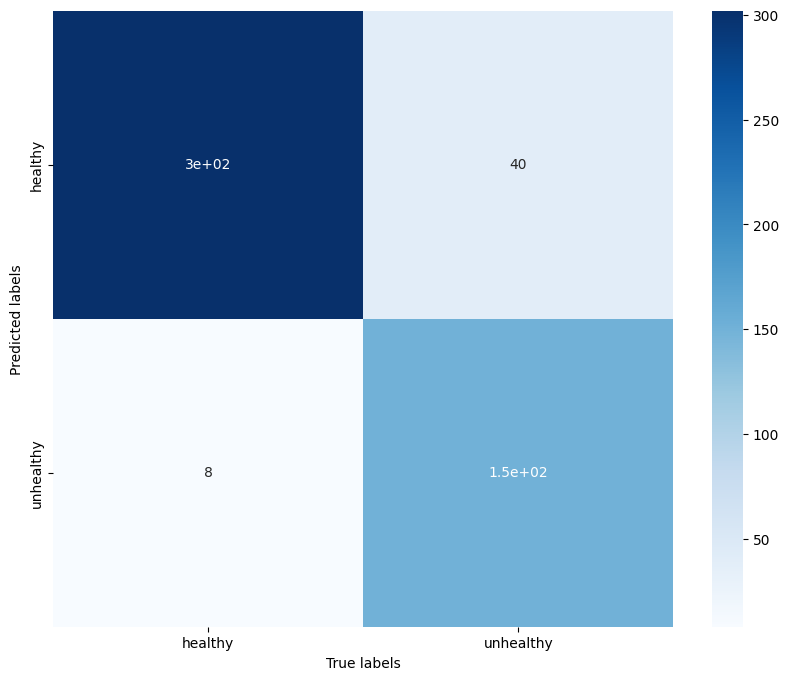

In [70]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(("healthy", "unhealthy")), yticklabels=list(("healthy", "unhealthy")), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [71]:
# Save the best model
model.save('ConvNextLarge_TL')
del model

# Fine Tuninig ConvNeXtLarge



In [72]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('ConvNextLarge_TL')
ft_model.summary()

Model: "convnext_large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 Flattening (Flatten)        (None, 1536)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               393472    
                                                    

In [73]:
# Set all ConvNeXtLarge layers as trainable
ft_model.get_layer('convnext_large').trainable = True
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 convnext_large_prestem_normalization True
2 convnext_large_stem True
3 convnext_large_stage_0_block_0_depthwise_conv True
4 convnext_large_stage_0_block_0_layernorm True
5 convnext_large_stage_0_block_0_pointwise_conv_1 True
6 convnext_large_stage_0_block_0_gelu True
7 convnext_large_stage_0_block_0_pointwise_conv_2 True
8 convnext_large_stage_0_block_0_layer_scale True
9 convnext_large_stage_0_block_0_identity True
10 tf.__operators__.add_36 True
11 convnext_large_stage_0_block_1_depthwise_conv True
12 convnext_large_stage_0_block_1_layernorm True
13 convnext_large_stage_0_block_1_pointwise_conv_1 True
14 convnext_large_stage_0_block_1_gelu True
15 convnext_large_stage_0_block_1_pointwise_conv_2 True
16 convnext_large_stage_0_block_1_layer_scale True
17 convnext_large_stage_0_block_1_identity True
18 tf.__operators__.add_37 True
19 convnext_large_stage_0_block_2_depthwise_conv True
20 convnext_large_stage_0_block_2_layernorm True
21 convnext_large_stage_0_block_2_poin

In [74]:
# Freeze first 84 layers
N = 84
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
  print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_3 False
1 convnext_large_prestem_normalization False
2 convnext_large_stem False
3 convnext_large_stage_0_block_0_depthwise_conv False
4 convnext_large_stage_0_block_0_layernorm False
5 convnext_large_stage_0_block_0_pointwise_conv_1 False
6 convnext_large_stage_0_block_0_gelu False
7 convnext_large_stage_0_block_0_pointwise_conv_2 False
8 convnext_large_stage_0_block_0_layer_scale False
9 convnext_large_stage_0_block_0_identity False
10 tf.__operators__.add_36 False
11 convnext_large_stage_0_block_1_depthwise_conv False
12 convnext_large_stage_0_block_1_layernorm False
13 convnext_large_stage_0_block_1_pointwise_conv_1 False
14 convnext_large_stage_0_block_1_gelu False
15 convnext_large_stage_0_block_1_pointwise_conv_2 False
16 convnext_large_stage_0_block_1_layer_scale False
17 convnext_large_stage_0_block_1_identity False
18 tf.__operators__.add_37 False
19 convnext_large_stage_0_block_2_depthwise_conv False
20 convnext_large_stage_0_block_2_layernorm False
21 convnext_large

In [75]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5, weight_decay=1e-4), metrics='accuracy')

In [76]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(data_train*255), # We need to apply the preprocessing thought for the ConvNeXt network
    y = labels_train,
    batch_size = 32,
    epochs = 180,
    validation_data = (preprocess_input(data_val*255), labels_val), # We need to apply the preprocessing thought for the ConvNeXt network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

Epoch 1/180
127/127 [==============================] - 155s 727ms/step - loss: 0.2593 - accuracy: 0.9237 - val_loss: 0.2371 - val_accuracy: 0.9002
Epoch 2/180
127/127 [==============================] - 72s 569ms/step - loss: 0.2159 - accuracy: 0.9282 - val_loss: 0.2270 - val_accuracy: 0.9002
Epoch 3/180
127/127 [==============================] - 75s 588ms/step - loss: 0.1818 - accuracy: 0.9408 - val_loss: 0.2116 - val_accuracy: 0.9157
Epoch 4/180
127/127 [==============================] - 75s 588ms/step - loss: 0.1475 - accuracy: 0.9563 - val_loss: 0.2001 - val_accuracy: 0.9224
Epoch 5/180
127/127 [==============================] - 74s 583ms/step - loss: 0.1363 - accuracy: 0.9571 - val_loss: 0.2090 - val_accuracy: 0.9157
Epoch 6/180
127/127 [==============================] - 74s 582ms/step - loss: 0.1459 - accuracy: 0.9536 - val_loss: 0.1854 - val_accuracy: 0.9157
Epoch 7/180
127/127 [==============================] - 74s 582ms/step - loss: 0.1263 - accuracy: 0.9595 - val_loss: 0.1884 

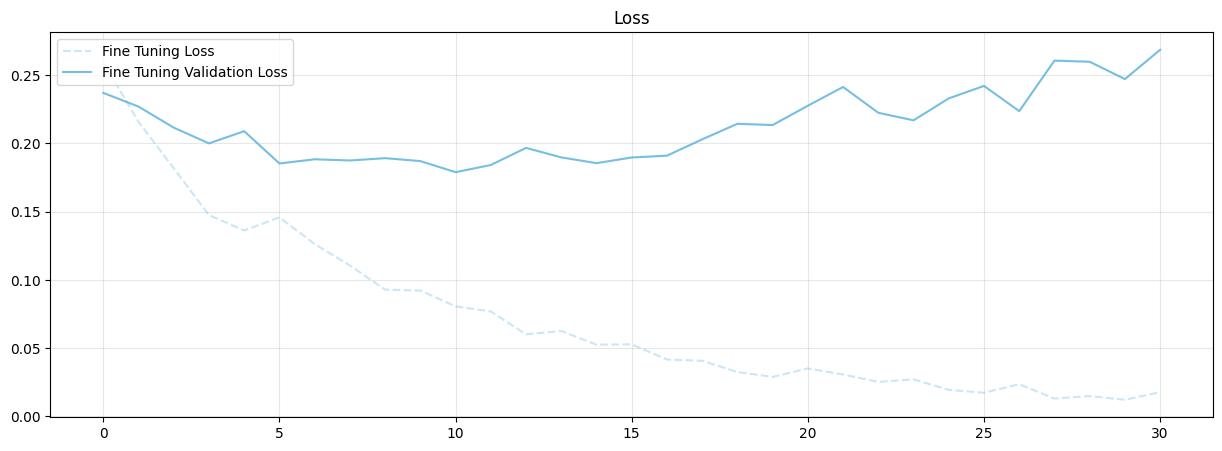

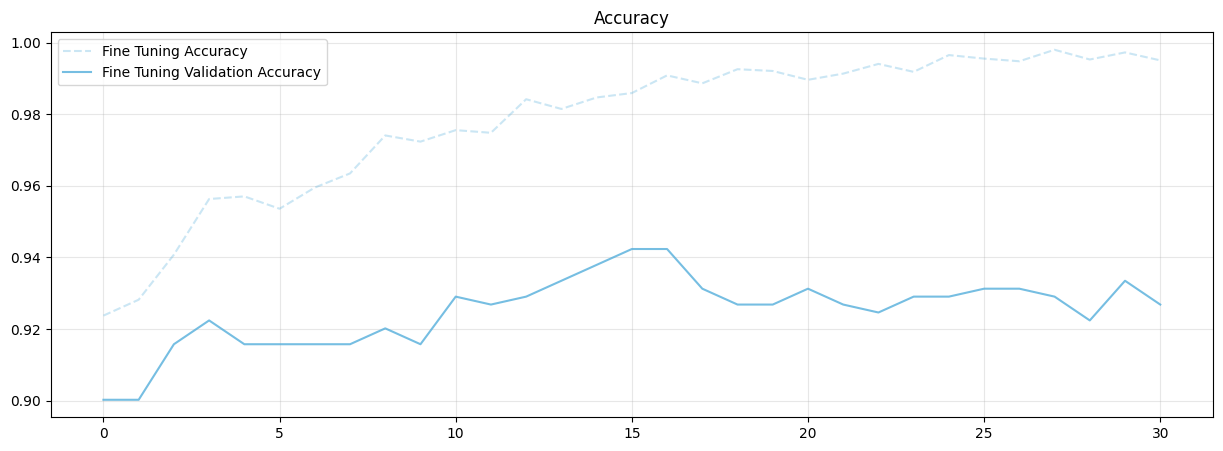

In [77]:
# Plot the fine tuning loss and val loss
plt.figure(figsize=(15,5))
plt.plot(ft_history['loss'], label="Fine Tuning Loss", alpha=.3, color='#54aedb', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning Validation Loss', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)

# Plot the fine tuning accuracy and val accuracy
plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], label='Fine Tuning Accuracy', alpha=.3, color='#54aedb', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning Validation Accuracy', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

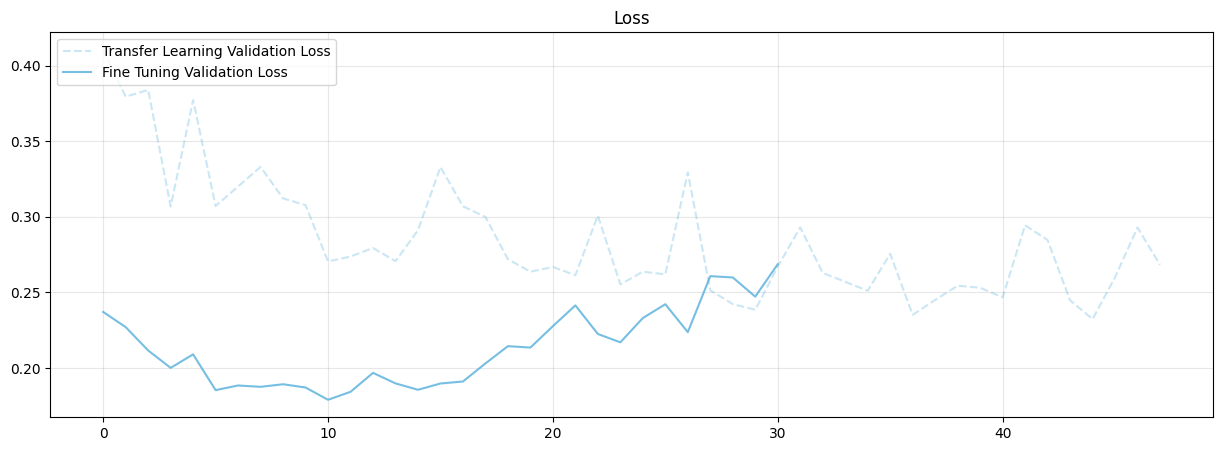

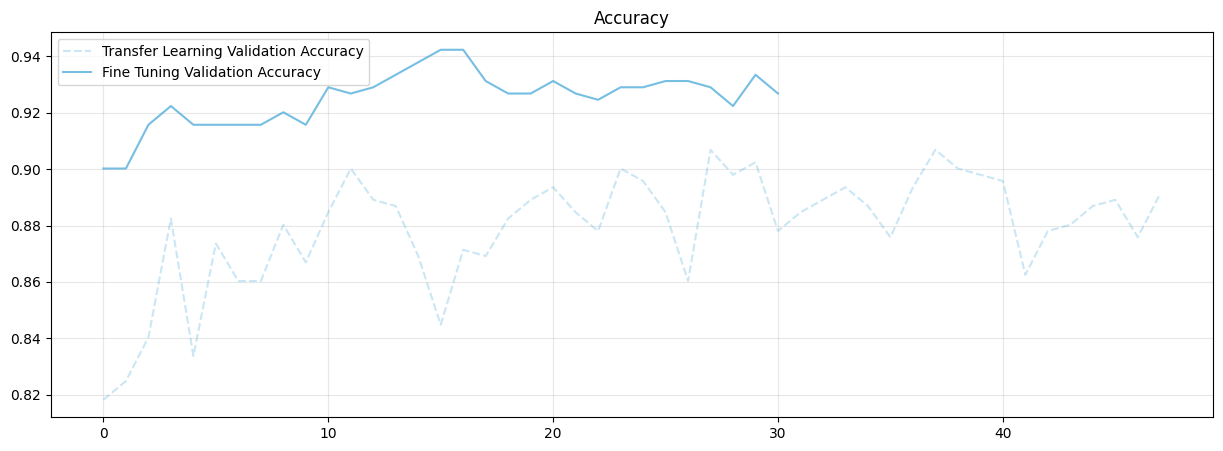

In [78]:
# Plot the transfer learning validation loss and fine tuning validation loss
plt.figure(figsize=(15,5))
plt.plot(history['val_loss'], label="Transfer Learning Validation Loss", alpha=.3, color='#54aedb', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning Validation Loss', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)

# Plot the transfer learning validation accuracy and fine tuning validation accuracy
plt.figure(figsize=(15,5))
plt.plot(history['val_accuracy'], label='Transfer Learning Validation Accuracy', alpha=.3, color='#54aedb', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning Validation Accuracy', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [79]:
# Predict labels for the entire test set
predictions = ft_model.predict(data_test*255, verbose=0)

In [80]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(data_test*255),labels_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.9421


In [81]:
y = np.array(labels_test)

## Confusion matrix

Accuracy: 0.9421
Precision: 0.949
Recall: 0.9291
F1: 0.9374


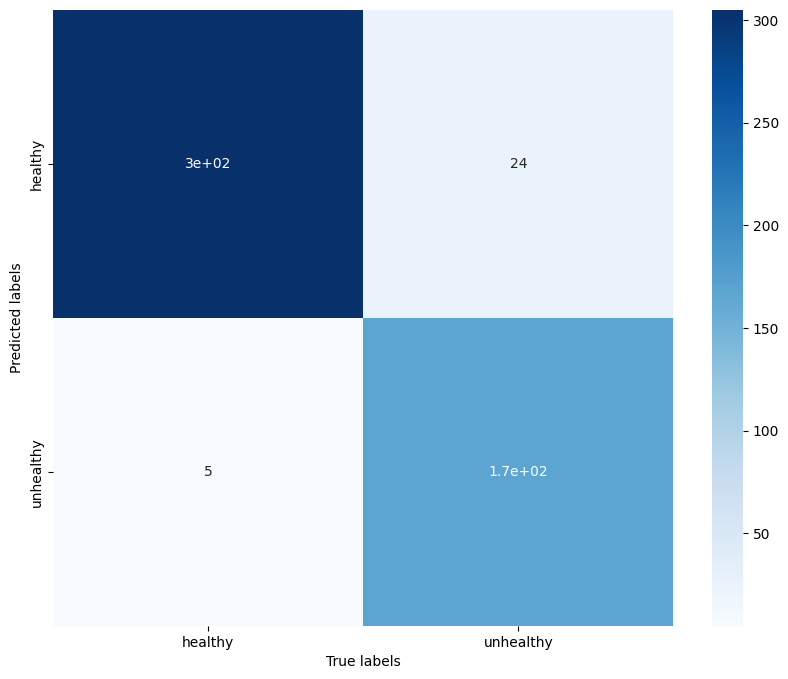

In [82]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(("healthy", "unhealthy")), yticklabels=list(("healthy", "unhealthy")), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [83]:
# Save the best model
ft_model.save('ConvNextLarge_TL+FT')

In [84]:
del ft_model